## Configuration for Colab

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

## 01. A2C
[Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.](http://proceedings.mlr.press/v48/mniha16.pdf)

### Actor-Critic

*Actor critic* method is one of the popular *policy optimization* algorithms. This approach maximizes the expected return by pushing up the probabilities of actions that receive higher returns. Let $\pi_\theta$ denote a policy with parameters $\theta$. The policy gradient of performance $\mathcal{J}(\pi_\theta)$ is

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right],$$

where $\tau$ is a trajectory and $A^{\pi_\theta}$ is the advantage function for reducing variance of values. The *policy gradient algorithm* updates the parameters by adding this gradient.

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k}),$$

where $\alpha$ is a learning rate. The agent is trained in an on-policy way because the parameters are updated by the current policy. We call the policy *Actor* which predicts probabilities of actions in each state, and call the value function *Critic* that predicts values of all state-action pairs. 


### Advantage Function

The advantage function effectively reduces the variance of values and is defined as follows.

$$ A(s,a) = Q(s,a) - V(s) $$

From this formula, we can replace Q with $r+\gamma V(s')$ and redefine Advantage function without using Action-Value function.

$$ A(s,a) = r + \gamma V(s') - V(s) $$


### Maximization Entropy

Entropy is a measure of unpredictability or a measure of randomness. If we have actions with almost equal probabilities, the entropy over the actions will be the largest because it's completely unpredictable which action will be chosen. In view of the fact, we can encourage exploration by adding entropy maximization term to the loss function. The entropy $H$ with respect to the probability $p$ over actions is

$$ H(P) = - \sum_a p(a) \log p(a) $$


## import module

In [14]:
import random
from typing import List, Tuple

# import gym
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed

In [15]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Network
We will use two separated networks for actor and critic respectively. The actor network consists of one fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Normal distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value that is multiplied by 2 after tanh. On the one hand, the critic network has two fully connected layers as a hidden layer (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [16]:
def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    """Initialize the weights and bias in [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.mu_layer = nn.Linear(128, out_dim)     
        self.log_std_layer = nn.Linear(128, out_dim)   
        
        initialize_uniformly(self.mu_layer)
        initialize_uniformly(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        
        mu = torch.tanh(self.mu_layer(x)) * 2
        log_std = F.softplus(self.log_std_layer(x))
        std = torch.exp(log_std)
        
        # pendulum action space is 1-dim https://www.gymlibrary.dev/environments/classic_control/pendulum/
        # https://pytorch.org/docs/stable/distributions.html#pathwise-derivative
        dist = Normal(mu, std)
        action = dist.sample()
        
        return action, dist
    
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)
        
        initialize_uniformly(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        value = self.out(x)
        
        return value

## A2C Agent
Here is a summary of A2CAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

In [27]:
class A2CAgent:
    """A2CAgent interacting with environment.
        
    Atribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, entropy_weight: float):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition (state, log_prob, next_state, reward, done)
        self.transition: list = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            # https://pytorch.org/docs/stable/distributions.html#pathwise-derivative
            # sample from distribution that can be backproped
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = [state, log_prob]
        
        return selected_action.clamp(-2.0, 2.0).cpu().detach().numpy()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, trunc, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition.extend([next_state, reward, done])           
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""  
        state, log_prob, next_state, reward, done = self.transition

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        next_state = torch.FloatTensor(next_state).to(self.device)
        pred_value = self.critic(state)
        targ_value = reward + self.gamma * self.critic(next_state) * mask
        value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
        
        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = (targ_value - pred_value).detach()  # not backpropagated
        
        # log_prob - see above
        # https://pytorch.org/docs/stable/distributions.html#pathwise-derivative
        policy_loss = -advantage * log_prob
        policy_loss += self.entropy_weight * -log_prob  # entropy maximization

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        # per step, per step, per episode
        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()[0]
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state = env.reset()[0]
                scores.append(score)
                score = 0                
            
            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()
    
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()[0]
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render())
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [28]:
env_id = "Pendulum-v1"
env = gym.make(env_id, render_mode="rgb_array")

## Initialize

In [29]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

cpu


## Train

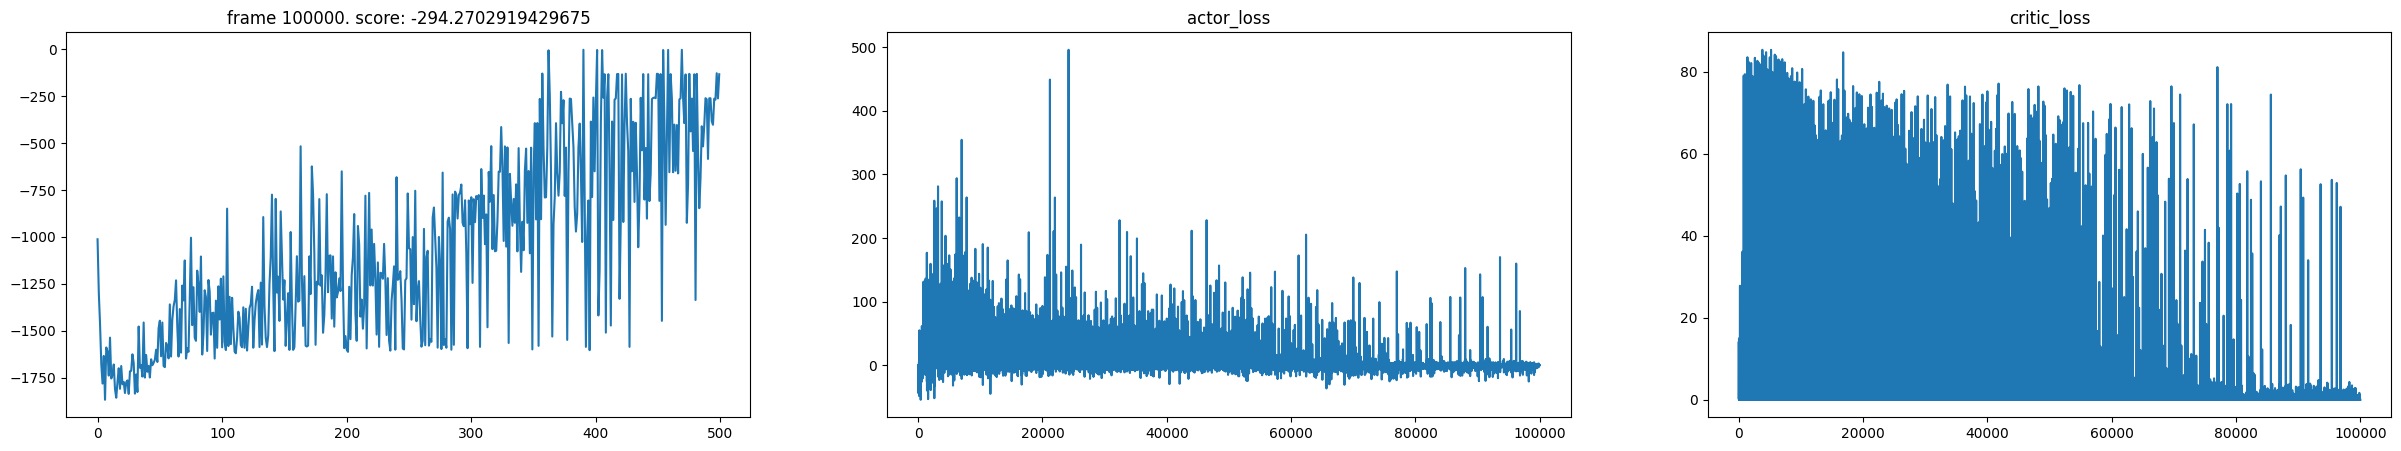

In [30]:
agent.train(num_frames)

## Test

In [32]:
# test
if IN_COLAB:
    agent.env = gym.wrappers.Monitor(agent.env, "videos", force=True)
frames = agent.test()

score:  -797.6508945441374


## Render

In [ ]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(frames)